<a href="https://colab.research.google.com/github/rHarris4080/Capstone3-Unsupervised-Learning-Project/blob/main/Capstone_3_vFinal_KModes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Capstone 3 - Unsupervised Learning: US Gun Violence Investigation**
##Robert Harris - 5/18/21
####Dec 2021 KModes Adjustment - After further research, I have implemented a KModes clustering approach due to the encoding of categorical features. 

The US has a Worldwide reputation as a country of uncontrolled gun violence. The US is a unique country in that its citizens have the right to own and bear arms as written in the 2nd Amendment. I found a few datasets of interest covering gun violence in one form or another.  While I liked one focused on police shootings I decided to pursue a more generalized one on raw gun violence from 2013-2018 on Kaggle.com.

##**Task:**
Write an unsupervised learning model to help identify some patterns associated with gun violence in the United States.  The dataset is comprised of 239,677 reported gun related incidents from 2013 to 2018 which can be found at https://www.kaggle.com/jameslko/gun-violence-data. 

##**Approach:** 
The dataset has a vast amount amount of information where extensive preliminary cleaning and exploratory data analysis dominated the early process.  A KModes clustering approach is implemented because of the categorical nature of the feature set. 

##**Stakeholders:**
Anyone interested in gaining any insight into gun violence in the US.  While many relationships would make common sense on the surface (ie drugs, gangs, robbery, etc...), any further insights gained could always be beneficial going forward.

##**Limitations:**
1. Dataset: Very little is known about the suspect as far as mental health and motive is concerned.  Some key words like robbery, gang vs gang, and drugs give us some indicating factors but these descriptors were only occasionally present. 
2. Work-Arounds: My self taught working knowledge of lambda functions is a work in progress.  While I have improved in their implementation, I still find myself reverting to more primititive work-arounds when pressed for time. 


##**Further Investigation:**
I would find it interesting to investigate the makeup of the suspects including but not limited to mental health, criminal history, educational level, employment history, and other pertinent personal information.  This could also be segued into a supervised learning model with a predictive component.  

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

#Set up access the dataset
from google.colab import files 
import io

uploaded = files.upload()
gun_df = pd.read_csv(io.BytesIO(uploaded['gun-violence-data_01-2013_03-2018.csv']))

Saving gun-violence-data_01-2013_03-2018.csv to gun-violence-data_01-2013_03-2018.csv


#**I. Preliminary Data Analysis:**

In [ ]:
df = gun_df.copy()
df.shape

(239677, 29)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   incident_id                  239677 non-null  int64  
 1   date                         239677 non-null  object 
 2   state                        239677 non-null  object 
 3   city_or_county               239677 non-null  object 
 4   address                      223180 non-null  object 
 5   n_killed                     239677 non-null  int64  
 6   n_injured                    239677 non-null  int64  
 7   incident_url                 239677 non-null  object 
 8   source_url                   239209 non-null  object 
 9   incident_url_fields_missing  239677 non-null  bool   
 10  congressional_district       227733 non-null  float64
 11  gun_stolen                   140179 non-null  object 
 12  gun_type                     140226 non-null  object 
 13 

#**II. Clean and Prepare Dataset:**
1. Initial Basic Cleaning.
2. Extract Counts and Quantities.
3. String and Key Word Descriptors.
4. Create Sub-Files (2018):





###**1. Initial Basic Cleaning:**

In [ ]:
# Eliminate non-essential information:
df.drop(['incident_id', 'address', 'incident_url', 'source_url', 'sources', 'incident_url_fields_missing', 
         'congressional_district', 'latitude', 'longitude', 'participant_name' , 'participant_age_group',
         'state_house_district', 'state_senate_district'], axis=1, inplace=True)

# Dissect dates for deeper analysis:
df["date"] = pd.to_datetime(df["date"])

df["day"] = df["date"].dt.day         # 1..31
df["month"] = df["date"].dt.month     # 1..12
df["year"] = df["date"].dt.year       # 2013..2018
df["weekday"] = df["date"].dt.weekday # 0..6
df["week"] = df["date"].dt.week       # 1-53

#df.drop(['date'], axis=1, inplace=True)    # Keep for the moment

# For unsupervised model - y_pred
df.loc[df["n_killed"] > 0, "fatality"] = 1
df[["fatality"]] = df[["fatality"]].fillna(value = 0).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


###**2. Extract Counts and Quantities:**

In [ ]:
# Fill nan 'n_guns_involved' with mean() because at least 1 gun is involved:
df.n_guns_involved = df.n_guns_involved.fillna(df.n_guns_involved.mean())

# These columns give logistical info like quantities in text format:
cats = ['gun_stolen','gun_type','participant_age','participant_gender',
        'participant_status','participant_type','participant_relationship']

# Convert to lowercase and standardize Nan with '0::unknown'
for cat in cats:
  df[cat] = df[cat].str.lower()
  df[cat] = df[cat].fillna("0::unknown")

In [ ]:
df.iloc[176]

date                                                      2013-08-19 00:00:00
state                                                                Illinois
city_or_county                                                        Chicago
n_killed                                                                    1
n_injured                                                                   4
gun_stolen                                                         0::unknown
gun_type                                                      0::7.62 [ak-47]
incident_characteristics    Shot - Wounded/Injured||Shot - Dead (murder, a...
location_description                                    Uptown Baptist Church
n_guns_involved                                                             1
notes                       Three gang members and two other individuals s...
participant_age                                                         5::20
participant_gender          0::male||1::male||2::male||3::male||

###Remove delimiters for records separating particulars:

In [ ]:
# Function returning a list of specifics by removing delimiters:

# Inspiration from kaggle contributers:
def dissect_str(row):
  values = []
  row_vals = str(row).split("||") # array of string without ||
  for s in row_vals:
    value = str(s).split("::")    # 2 element array value = ['index', 'actual value']
    if len(value)>1:              # Needed for later side-effect.
      values.append(value[1])     # append the 'actual value' component into the array 

  return values   

###Determine number of suspects, victims, and arrests:

In [ ]:
# Participants as suspect or victim
part_t = df.participant_type.apply(dissect_str)                         # array of participant descriptions
df["n_suspects"] = part_t.apply(lambda x: x.count("subject-suspect"))
df["n_victims"] = part_t.apply(lambda x: x.count("victim"))

df.drop(['participant_type'], axis=1, inplace=True)
del(part_t)

# Participants by gender
part_g = df.participant_gender.apply(dissect_str)
df["n_Males"] = part_g.apply(lambda x: x.count("male"))
df["n_Females"] = part_g.apply(lambda x: x.count("female"))

df.drop(['participant_gender'], axis=1, inplace=True)
del(part_g)

# Number of arrests:
part_s = df.participant_status.apply(dissect_str)
df["n_arrests"] = part_s.apply(lambda x: x.count("arrested"))

df.drop(['participant_status'], axis=1, inplace=True)
del(part_s)

###Determine gun particulars (stolen or not) per incident:

In [ ]:
# Count stolen guns
stolen_g = df.gun_stolen.apply(dissect_str)
df["n_guns_stolen"] = stolen_g.apply(lambda x: x.count("stolen"))

df.drop(['gun_stolen'], axis=1, inplace=True)
del(stolen_g)

### Distinguish between number of handguns and rifles per incident:

In [ ]:
# The following adjust text delimiters to recognize all guns.
df['gun_type'] = df['gun_type'].str.replace("|", "||")
df['gun_type'] = df['gun_type'].str.replace(":", "::")
df['gun_type'] = df['gun_type'].str.replace("::::", "::")

gun_list = df.gun_type.apply(dissect_str)

In [ ]:
# One list of accumulate guns
acc_guns = []
for i, per_inc in enumerate(gun_list):
  if len(per_inc)==1:
    acc_guns.append(per_inc[0])
  else:
    for inc in per_inc:
      acc_guns.append(inc)

In [ ]:
# Distinguish between handguns and rifles:
handgun_t = ['handgun', '10mm', '9mm', '45 auto', '44 mag', '40 sw', '380 auto', 
             '38 spl', '357 mag', '32 auto', '25 auto', 'other', 'unknown']

rifle_t = ['28 gauge', '30-06 spr', '300 win', 'shotgun', '308 win', '16 gauge', '410 gauge', 
           '30-30 win', 'rifle', '7.62 [ak-47]', '223 rem [ar-15]', '20 gauge', '12 gauge','22 lr']

# Count the number of handguns:
n_handguns = pd.DataFrame()
for gun in handgun_t:
  n_handguns[gun] = gun_list.apply(lambda x: x.count(gun))

df['n_handguns'] = n_handguns.sum(axis=1)

# Count the number of rifles:
n_rifles = pd.DataFrame()
for gun in rifle_t:
  n_rifles[gun] = gun_list.apply(lambda x: x.count(gun))

df['n_rifles'] = n_rifles.sum(axis=1)

df["n_guns_involved"] = df['n_handguns'] + df['n_rifles']
df.drop(['gun_type'], axis=1, inplace=True)

###Re-adjusting 'unknown' to 'handgun'

In [ ]:
gun_df = pd.DataFrame(acc_guns, columns=['type'])
gun_df[gun_df['type']=='unknown'] = 'handgun'
specific_guns = gun_df['type'].value_counts().to_dict()

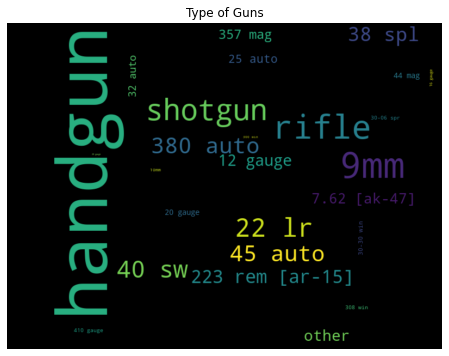

In [ ]:
from wordcloud import WordCloud

# Wordcloud Visual:
wordcloud = WordCloud(height=600, width=800)
wordcloud.generate_from_frequencies(frequencies=specific_guns)
plt.figure(figsize=(14,6))
plt.title('Type of Guns')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

###Determine the average age of all participants per incident:

In [ ]:
# Determine the age count per incident:
ages = pd.DataFrame()

age_list = df.participant_age.apply(dissect_str)        # array of ages
ages["age_ct"]= age_list.apply(lambda x: len(x))

# Struggled with ave age - following is a work around:
df["ave_age"] = ages["age_ct"]

for recd in range(len(age_list)):
  sum=0
  for c in range(len(age_list.iloc[recd])):
    if age_list.iloc[recd][c] != 'unknown':
      sum +=  int(age_list.iloc[recd][c])
    
  df["ave_age"].iloc[recd] = sum//ages["age_ct"][recd]

df.drop([ "participant_age"], axis=1, inplace=True )

# Replace ave age of zero with overall average of all participants:
df.loc[ df.ave_age == 0, "ave_age" ] = df[ df.ave_age != 0 ].ave_age.mean()

df.ave_age = df.ave_age.round().astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()


###Age Outliers and nulls replaced with mean()

In [ ]:
df["ave_age"].fillna(value = df["ave_age"].mean(), inplace=True)

df.loc[ df.ave_age >105, "ave_age" ] = df[ df.ave_age!=0].ave_age.mean()

###**3. String and Key Word Descriptors:**

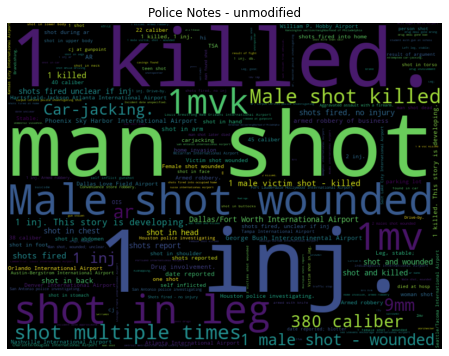

In [ ]:
from wordcloud import WordCloud

freq_notes = df['notes'].value_counts().to_dict()

wordcloud = WordCloud(height=600, width=800)
wordcloud.generate_from_frequencies(frequencies=freq_notes)
plt.figure(figsize=(14,6))
plt.title('Police Notes - unmodified')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

###The following categories all have important text descriptors(i.e. drugs, felon, domestic violence, suicide, etc...):
1. incident_characteristics
2. location_description
3. participant_relationship
4. notes

###Some of these text key_words will be extracted and used as indicators for a particular incident.

In [ ]:
# Theses 4 columns give incident descriptors:
df.incident_characteristics = df.incident_characteristics.str.lower()
df.location_description = df.location_description.str.lower()
df.participant_relationship = df.participant_relationship.str.lower()
df.notes = df.notes.str.lower()


###Extract relationship key words between suspect(s) and victim(s) if any exist:

In [ ]:
# Find the unique relationships involved by dissecting delimited relationships:
relationship = []
for i, each in df.iterrows():
    wrds = each['participant_relationship'].split("||")
    for wrd in wrds:
        wrd = wrd.replace("::",":").replace("|1","")       
        gtype = wrd.split(":")[1]   
        #if gtype not in relationship:        
        relationship.append(gtype)


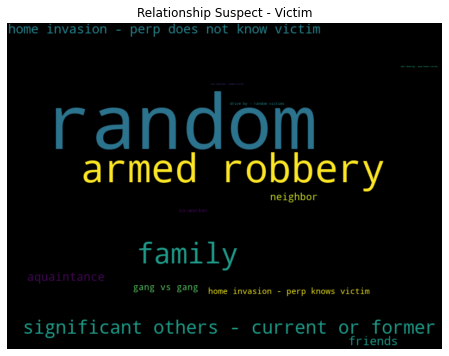

In [ ]:
# Wordcloud Visual:
from wordcloud import WordCloud

relationship_t = pd.DataFrame(relationship, columns = ["type"])
relationship_t.loc[relationship_t["type"]=='unknown', "type" ] = 'random'
rel = relationship_t["type"].value_counts().to_dict()

wordcloud = WordCloud(height=600, width=800)
wordcloud.generate_from_frequencies(frequencies=rel)
plt.figure(figsize=(14,6))
plt.title('Relationship Suspect - Victim')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##Location Frequencies:

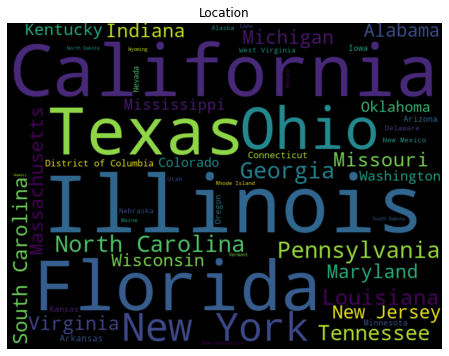

In [ ]:
# State 
state = df['state'].value_counts().to_dict()

# Wordcloud Visual:
wordcloud = WordCloud(height=600, width=800)
wordcloud.generate_from_frequencies(frequencies=state)
plt.figure(figsize=(14,6))
plt.title('Location')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

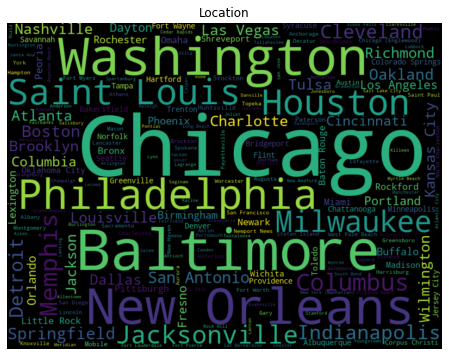

In [ ]:
# Cities 
city = df['city_or_county'].value_counts().to_dict()

# Wordcloud Visual:
wordcloud = WordCloud(height=600, width=800)
wordcloud.generate_from_frequencies(frequencies=city)
plt.figure(figsize=(14,6))
plt.title('Location')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

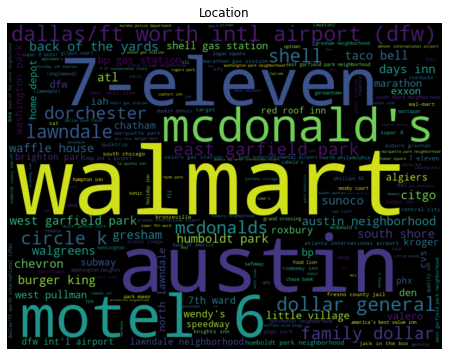

In [ ]:
# Location 
freq_loc = df['location_description'].value_counts().to_dict()

# Wordcloud Visual:
wordcloud = WordCloud(height=600, width=800)
wordcloud.generate_from_frequencies(frequencies=freq_loc)
plt.figure(figsize=(14,6))
plt.title('Location')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Function to dissect row as a string
def dissect(row):
  values = ""
  row_vals = str(row).split("||") 
  for s in row_vals:
    values += s

  return values  # return 1 string 

###Dissect 'characteristics' text feature.

In [ ]:
# Separate characteristics into 1 string per incident:
df['characteristics'] = df.incident_characteristics.apply(dissect)
#df['atf'] = df[df.n_guns_involved>5]['incident_characteristics'].str.find("atf")!=-1
df.drop(["incident_characteristics"],inplace=True,axis=1)

In [ ]:
# Search for these key words:  
incident = ['robbery','car-jacking','kidnapping','drive-by', 'mass']
location = ['bar', 'school','apartment','restaurant','home','car','work','church']
who_involved = ['domestic','neighbor','friend','co-worker','officer','child','acquaintance','random', 'gang','roommate']
attribute = ['felon', 'stolen', 'shot', 'alcohol', 'drug','warrant','atf']
outcome = ['suicide', 'arrest','injured']

key_words = incident +location +who_involved +attribute

###Take ALL key words and combine for dissection.

In [ ]:
# Fill in nan fields with empty strings for identifying key_words per incident:
df[["characteristics", "participant_relationship", "notes", "location_description"]] = df[["characteristics", "participant_relationship", "notes", "location_description"]].fillna(value="")

# Concatenate as one string to search for key_words
df["descriptors"] = df["characteristics"] + df["participant_relationship"] + df["notes"] + df['location_description']

# Drop individual text descriptors
df.drop(["characteristics", "participant_relationship", "notes", "location_description"],inplace=True,axis=1)

###Re-classify overlapping categories.

In [ ]:
df.descriptors = df.descriptors.str.replace("wounded","injured")
df.descriptors = df.descriptors.str.replace("family","domestic")
df.descriptors = df.descriptors.str.replace("significant others","domestic")
df.descriptors = df.descriptors.str.replace("club","bar")
df.descriptors = df.descriptors.str.replace("tavern","bar")
df.descriptors = df.descriptors.str.replace("police","officer")


###Encode descriptors

In [ ]:
# Create a new specific key word category:
for key in key_words:
  df[key] = df["descriptors"].apply(lambda x: 1 if key in x else 0)

df.drop(["descriptors"], axis=1, inplace=True )                                 

##Investigate key_word descriptors to see if we can eliminate some:

In [ ]:
wrd_dict = {}
# Find quantities of descriptors:
for col in key_words:
  wrd_dict.update({col:len(df[df[col]!=0])})
  pct = len(df[df[col]!=0])/len(df)
  if pct < 0.01:
    print(col, ":\t", pct)

mass :	 0.007334871514580039
restaurant :	 0.003575645556311202
work :	 0.003938634078363798
church :	 0.0027203277744631315
co-worker :	 0.0006633928161650888
acquaintance :	 0.0006216699975383537
random :	 0.0010639318749817463
roommate :	 0.0011682389215485842


In [ ]:
# Drop columns that are not well represented:
df.drop(["mass","restaurant","work","church", "co-worker", "acquaintance", "random", "roommate"], axis=1, inplace=True)

###Separate to 3 Datasets:
1. df_no_loc
2. df_states
3. df_both_loc

In [ ]:
df_no_loc = df.copy()
df_states = df.copy()
df_both = df.copy()
df_blank = df.copy()

df_states.drop(["city_or_county"], axis=1, inplace=True)
df_states.reset_index(drop=True, inplace=True)

df_no_loc.drop(["state","city_or_county"], axis=1, inplace=True)
df_no_loc.reset_index(drop=True, inplace=True)

df_blank.drop(["state","city_or_county","date", "year"], axis=1, inplace=True)
df_blank.reset_index(drop=True, inplace=True)

#**III. Unsupervised Learning Component:**

In [ ]:
!pip install kmodes

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from kmodes.kmodes import KModes

###Find K for KModes from Elbow Curve.

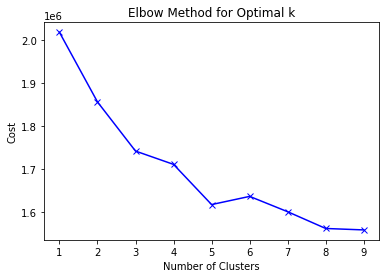

In [ ]:
# Elbow curve to find optimal k

cost = []
k = range(1,10)
for num_clusters in list(k):
  kmode = KModes(n_clusters=num_clusters, init="random", n_init=5, verbose=0)
  kmode.fit_predict(df_blank)
  cost.append(kmode.cost_)

plt.plot(k, cost, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title(('Elbow Method for Optimal k'))
plt.show()

##Implementing KModes
###Elbow curve levels out at 5 or 8.  We'll investigate k=5 clusters.

In [ ]:
kmode = KModes(n_clusters=5,init="random", n_init=5, verbose=0)
clusters = kmode.fit_predict(df_blank)
clusters

array([2, 0, 0, ..., 2, 3, 0], dtype=uint16)

In [ ]:
df_blank.insert(0, "cluster", clusters, True)
df_blank.head()

,cluster,n_killed,n_injured,n_guns_involved,day,month,weekday,week,fatality,n_suspects,n_victims,n_Males,n_Females,n_arrests,n_guns_stolen,n_handguns,n_rifles,ave_age,robbery,car-jacking,kidnapping,drive-by,bar,school,apartment,home,car,domestic,neighbor,friend,officer,child,gang,felon,stolen,shot,alcohol,drug,warrant,atf
0,2,0,4,1,1,1,1,1,0,1,4,3,1,1,0,1,0,20.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,1,3,1,1,1,1,1,1,1,4,1,0,0,0,1,0,20.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
2,0,1,3,2,1,1,1,1,1,2,3,5,0,0,0,2,0,31.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,4,0,1,5,1,5,1,1,1,3,3,1,0,0,1,0,37.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0
4,0,2,2,2,7,1,0,2,1,1,3,2,2,0,0,2,0,31.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0


###Separate cluster DataFrames

In [ ]:
cluster0 = df_blank[df_blank["cluster"]==0]
cluster1 = df_blank[df_blank["cluster"]==1]
cluster2 = df_blank[df_blank["cluster"]==2]
cluster3 = df_blank[df_blank["cluster"]==3]
cluster4 = df_blank[df_blank["cluster"]==4]

In [ ]:
cluster_t = [cluster0, cluster1, cluster2, cluster3, cluster4]

print("Cluster Length")
for i, cluster in enumerate(cluster_t):
  print(i, ":\t", len(cluster))

Cluster Length
0 :	 38145
1 :	 53517
2 :	 74610
3 :	 21935
4 :	 51470


###Incidents per cluster by Day of Week

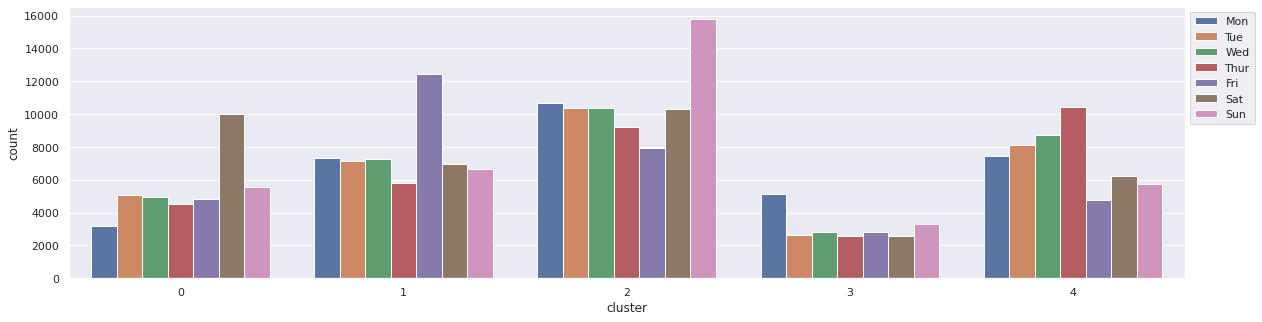

In [ ]:
import seaborn as sns

#plt.subplots(figsize=(20, 12))
plt.figure(figsize=(20,5))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="cluster", hue="weekday", data=df_blank)
plt.legend(labels=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"], loc=2, bbox_to_anchor=(1,1))

###Observations

###Incidents per cluster by Month

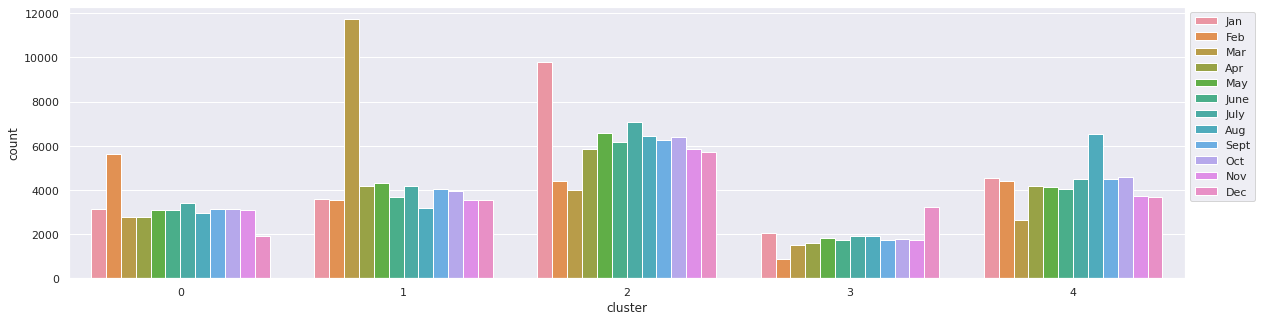

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="cluster",  hue='month', data=df_blank)
plt.legend(labels=["Jan","Feb","Mar","Apr","May","June","July","Aug","Sept","Oct","Nov","Dec"], loc=2, bbox_to_anchor=(1,1))

###Incidents per cluster by Week

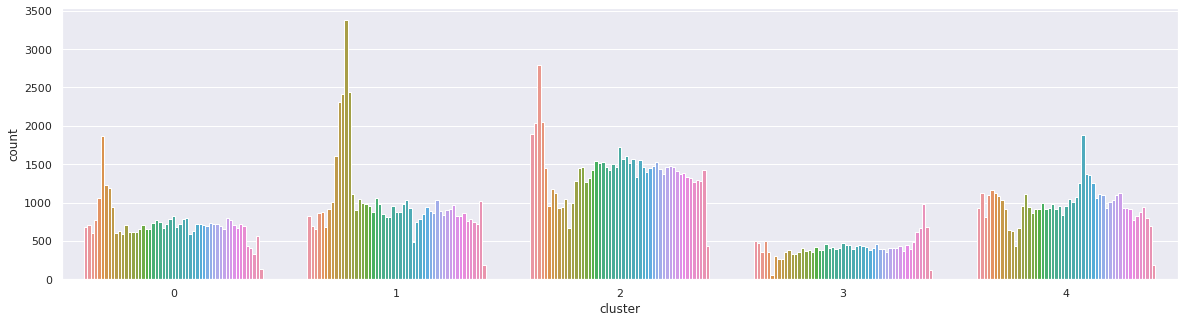

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="cluster", hue="week", data=df_blank)
ax.get_legend().remove()

###Fatalities per cluster

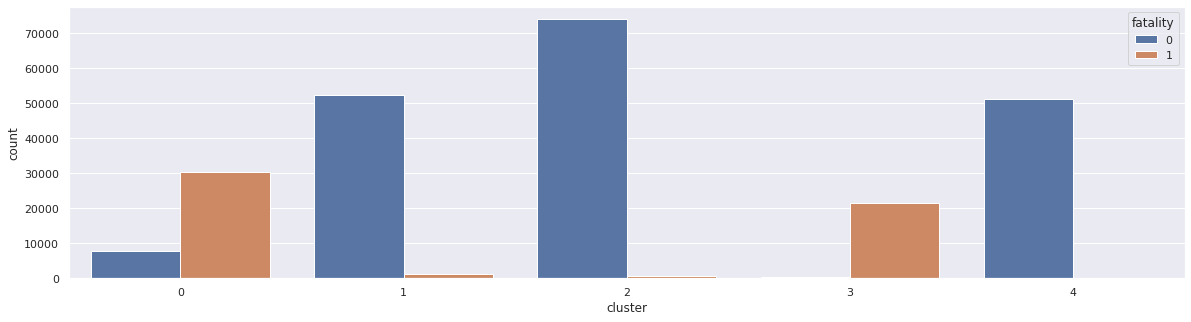

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x="cluster", hue="fatality", data=df_blank)

###Compare Mean Attributes per cluster.

In [ ]:
data = [cluster0.mean(),cluster1.mean(),cluster2.mean(),cluster3.mean(),cluster4.mean()]
headers = ['cluster0','cluster1','cluster2','cluster3','cluster4']
comp_means_df = pd.concat(data, axis=1, keys=headers)
comp_means_df = comp_means_df.reset_index()

avg_summary = pd.concat([comp_means_df.iloc[1:4], comp_means_df.iloc[8:18]])
avg_summary.set_index('index', inplace=True)

In [ ]:
avg_summary

,cluster0,cluster1,cluster2,cluster3,cluster4
index,,,,,
n_killed,0.922926,0.025562,0.010910,1.044951,0.003109
n_injured,0.384716,0.404414,1.029353,0.130613,0.046998
n_guns_involved,1.059667,1.397201,1.031484,1.023615,1.501768
fatality,0.794862,0.021096,0.008015,0.987509,0.002603
n_suspects,1.157137,0.620214,0.621565,0.265557,1.289722
n_victims,1.228995,0.454566,1.065554,1.126328,0.275617
n_Males,1.995360,0.707271,1.336550,1.133212,1.273771
n_Females,0.285280,0.129062,0.177550,0.174561,0.145930
n_arrests,0.066221,0.035428,0.022396,0.012902,0.073693


###Compare Maximum Attributes per cluster.

In [ ]:
data = [cluster0.max(),cluster1.max(),cluster2.max(),cluster3.max(),cluster4.max()]
comp_max_df = pd.concat(data, axis=1, keys=headers)
comp_max_df = comp_max_df.reset_index()

max_summary = pd.concat([comp_max_df.iloc[1:4], comp_max_df.iloc[8:18]])
max_summary.set_index('index', inplace=True)

In [ ]:
max_summary.iloc[1:18,]

,cluster0,cluster1,cluster2,cluster3,cluster4
index,,,,,
n_injured,53.0,15.0,19.0,19.0,7.0
n_guns_involved,47.0,400.0,48.0,81.0,400.0
fatality,1.0,1.0,1.0,1.0,1.0
n_suspects,14.0,63.0,10.0,10.0,52.0
n_victims,102.0,19.0,27.0,35.0,13.0
n_Males,61.0,60.0,16.0,14.0,29.0
n_Females,23.0,6.0,10.0,11.0,13.0
n_arrests,6.0,35.0,10.0,5.0,29.0
n_guns_stolen,47.0,60.0,30.0,30.0,70.0


###Compute totals per cluster.

In [ ]:
data = [cluster0.sum(),cluster1.sum(),cluster2.sum(),cluster3.sum(),cluster4.sum()]
headers = ['cluster0','cluster1','cluster2','cluster3','cluster4']
comp_sums_df = pd.concat(data, axis=1, keys=headers)
comp_sums_df = comp_sums_df.reset_index()
comp_sums_df.rename(columns={'index':'attribute'}, inplace=True)

pd.set_option('display.float_format', lambda x:'%.0f' %x)


In [ ]:
tot_summary = pd.concat([comp_sums_df.iloc[1:4], comp_sums_df.iloc[8:17], comp_sums_df.iloc[18:40]])
tot_summary.set_index('attribute', inplace=True)

###The following represents the specific number of occurences per 1000 incidents.

In [ ]:
tot_summary_1k = tot_summary.copy()

tot_summary_1k['cluster0'] = tot_summary_1k['cluster0']/(len(cluster0)/1000)
tot_summary_1k['cluster1'] = tot_summary_1k['cluster1']/(len(cluster1)/1000)
tot_summary_1k['cluster2'] = tot_summary_1k['cluster2']/(len(cluster2)/1000)
tot_summary_1k['cluster3'] = tot_summary_1k['cluster3']/(len(cluster3)/1000)
tot_summary_1k['cluster4'] = tot_summary_1k['cluster4']/(len(cluster4)/1000)

In [ ]:
tot_summary_1k

,cluster0,cluster1,cluster2,cluster3,cluster4
attribute,,,,,
n_killed,923,26,11,1045,3
n_injured,385,404,1029,131,47
n_guns_involved,1060,1397,1031,1024,1502
fatality,795,21,8,988,3
n_suspects,1157,620,622,266,1290
n_victims,1229,455,1066,1126,276
n_Males,1995,707,1337,1133,1274
n_Females,285,129,178,175,146
n_arrests,66,35,22,13,74


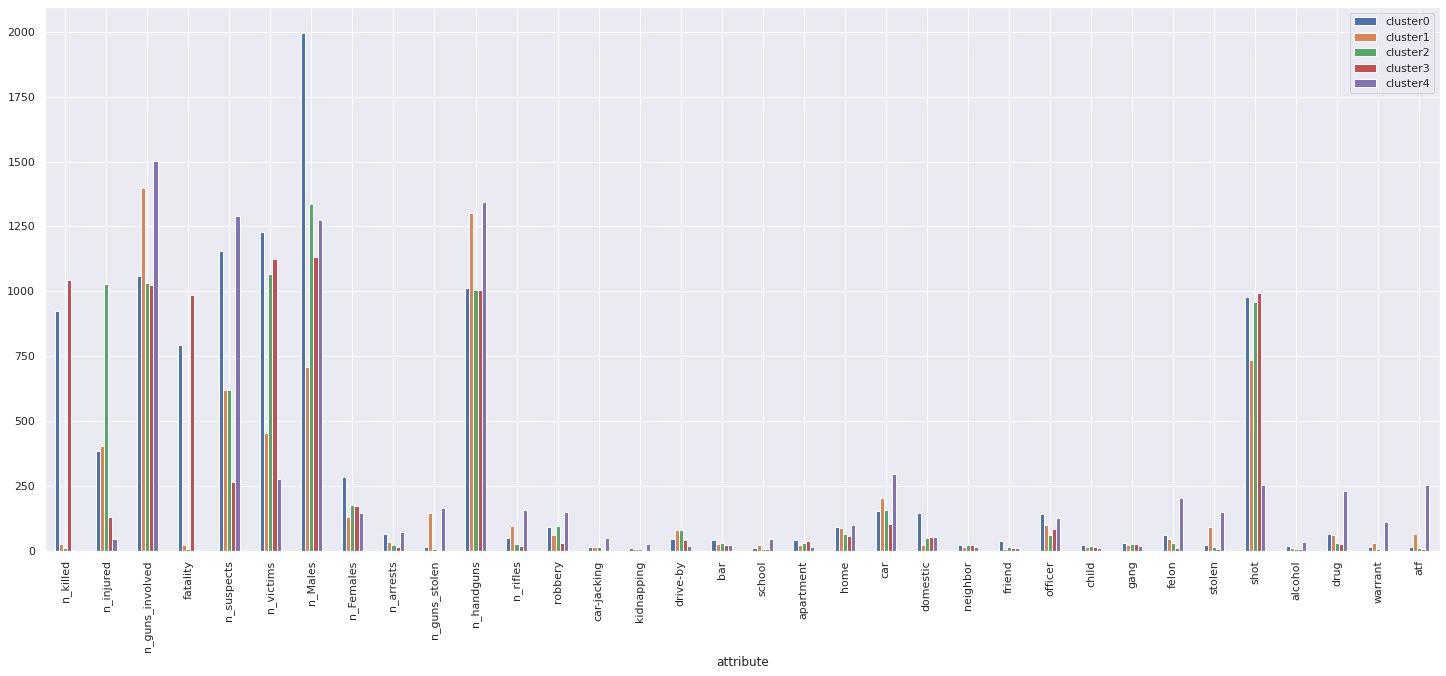

In [ ]:
tot_summary_1k.plot(kind='bar', figsize=(25,10))

##Observations:
###The model suggested 5 clusters.
###I. Fatalaties per 1000 - Mostly clustered in 'cluster3' & 'cluster0'
1. cluster3: 1045
2. cluster0: 923
3. cluster1: 26
4. cluster2: 11
5. cluster0: 3

###II. Cluster3 Results per 1000 incidents:

*   Smallest cluster at 21.9K incidents
*   Most likely to occur on Mondays in December
*   Only 13 arrests
*   Minimal amount of information as it had the smallest amount per cluster in 12 categories.

###III. Cluster0 Results per 1000 incidents:

*   Second smallest cluster at 38.1K incidents
*   Most likely to occur on Saturdays in February
*   Better than cluster3 with 66 arrests
*   The following categories had the most amount of incidents per cluster:

1.   Victims: 1229
2.   Bar: 41
3.   Apartment: 41
4.   Domestic: 146
5.   Friend: 38

###IV. Cluster4 Results per 1000 incidents: 

*   Median sized cluster at 51.5K incidents
*   Most likely to occur on Wednesdays in August
*   One of the more descriptive clusters

*   Categories with the least amount of incidents per cluster:

1.   Fatalities: 3
2.   Victims: 276
3.   Shots fired: 252

*   Categories with the most amount of incidents per cluster:

1.   Arrests: 74
2.   Stolen_guns: 165
3.   Robberies: 148
4.   Car-jackings: 50
5.   Kidnapping: 26
6.   Schools: 44
7.   Cars: 297
8.   Felons: 202
9.   Stealing: 151
10.  Drugs: 230
11.  Feds: 252

###V. Cluster1 & cluster2 Results per 1000 incidents: 

*   2 largest sized clusters at 53.5K & 74.6K incidents respectively
*   Cluster1 most likely to occur on Fridays in March
*   Cluster2 most likely to occur on Sundays in January
*   Both clusters seem to give little insight
*   Cluster2 reveals the most injuries at 1029
*   Both clusters do have the most drive-by incidents at 81 & 78 respectively, but those do not seem significant out of 1000 incidents.




  

##In Conclusion:
While some insights can be obtained from the observed clustering, I feel much more could be gained from further investigations by doing a deeper dive into the relationships that might exist.

I will conclude with the following observations from my perspective:
1. I find it interesting that 4 of the 5 clusters(0-3) reported shots fired at least 74% of the time (97.8, 73.7, 96.0, 99.3).
2. Likewise, it is fascinating that cluster4 with the fewest fatalities of 3 per 1000 has the most incidents in the 12 of the categories per cluster.   Some category leaders of interest are:
* Stolen guns 16.5%
* Robberies 14.8%
* Felons 20.2%
* Drugs 23%
* Fed Involvement 25.2%
3. The average age of everyone involved is between 28.8 & 31.5 years of age.
4. Incidents involving cars are the most prevelant.
5. The relatively small number of arrests is troubling.